<a href="https://colab.research.google.com/github/luoChengwen/Tensorflow_test/blob/master/time_series_forecasting_sun_spot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 32.9MB/s 
     |████████████████████████████████| 501kB 39.7MB/s 
     |████████████████████████████████| 3.1MB 20.0MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-08-21 01:33:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-08-21 01:33:02 (93.9 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [6]:
import csv
import pandas as pd
time_step = []
sunspots = []

data = pd.read_csv('/tmp/sunspots.csv')
print(data.head())
# with open('/tmp/sunspots.csv') as csvfile:
#   reader = csv.reader(csvfile, delimiter=',')
#   next(reader)
#   for row in reader:
#     sunspots.append(float(row[2]))
#     time_step.append(int(row[0]))


   Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7


Index(['Unnamed: 0', 'Date', 'Monthly Mean Total Sunspot Number'], dtype='object')
[datetime.datetime(1749, 1, 31, 0, 0) datetime.datetime(1749, 2, 28, 0, 0)
 datetime.datetime(1749, 3, 31, 0, 0)]


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


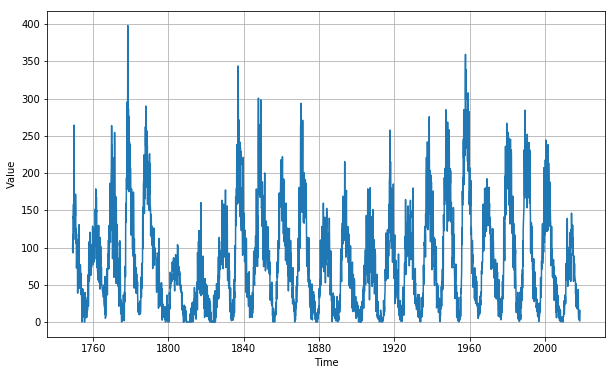

In [7]:
from dateutil import parser
print(data.columns)
sunspots = data.iloc[:,-1]
series = np.array(sunspots)
time_step = data.loc[:,'Date']
time_step = [parser.parse(i) for i in time_step]
time = np.array(time_step)
print(time[:3])
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
print(len(series))

3235


In [0]:

split_time = 2900
# time_train = time[:split_time]
x_train = series[:split_time]
# time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 64
shuffle_buffer_size = 700



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)  # window size + 1 is because you are using the last one as prediction
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)




In [13]:

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size = 5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1000)   # this is to amplify the results and help with the loss function calculation
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2900,)
Epoch 1/100


W0821 01:33:07.849076 140030323185536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


12/12 [==============================] - 7s 620ms/step - loss: 79.2910 - mae: 80.3558
Epoch 2/100
12/12 [==============================] - 5s 409ms/step - loss: 73.4723 - mae: 74.4138
Epoch 3/100
12/12 [==============================] - 5s 414ms/step - loss: 66.6791 - mae: 67.4174
Epoch 4/100
12/12 [==============================] - 5s 416ms/step - loss: 60.8999 - mae: 61.4287
Epoch 5/100
12/12 [==============================] - 5s 416ms/step - loss: 56.4528 - mae: 56.8271
Epoch 6/100
12/12 [==============================] - 5s 412ms/step - loss: 53.0053 - mae: 53.2946
Epoch 7/100
12/12 [==============================] - 5s 415ms/step - loss: 50.0552 - mae: 50.3141
Epoch 8/100
12/12 [==============================] - 5s 412ms/step - loss: 47.1752 - mae: 47.4403
Epoch 9/100
12/12 [==============================] - 5s 409ms/step - loss: 44.0907 - mae: 44.3925
Epoch 10/100
12/12 [==============================] - 5s 408ms/step - loss: 40.7075 - mae: 41.0717
Epoch 11/100
12/12 [===========

dict_keys(['loss', 'mae', 'lr'])


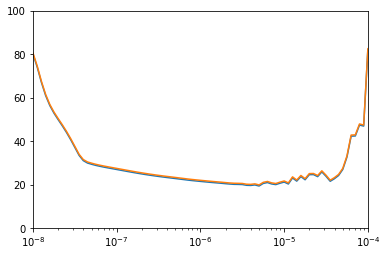

In [15]:
print(history.history.keys())
np.array(history.history['loss']).mean()
plt.axis([1e-8, 1e-4, 0, 100])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.plot(history.history["lr"],history.history["mae"])


In [16]:
tf.keras.backend.clear_session()
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1000)
])


optimizer = tf.keras.optimizers.SGD(lr=3*1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
29/29 [==============================] - 6s 215ms/step - loss: 55.7491 - mae: 56.6212
Epoch 2/500
29/29 [==============================] - 4s 130ms/step - loss: 52.9671 - mae: 53.5620
Epoch 3/500
29/29 [==============================] - 4s 129ms/step - loss: 37.8488 - mae: 38.4327
Epoch 4/500
29/29 [==============================] - 4s 127ms/step - loss: 38.3031 - mae: 38.8352
Epoch 5/500
29/29 [==============================] - 4s 130ms/step - loss: 34.9004 - mae: 35.1991
Epoch 6/500
29/29 [==============================] - 4s 128ms/step - loss: 31.5007 - mae: 32.1083
Epoch 7/500
29/29 [==============================] - 4s 125ms/step - loss: 47.8744 - mae: 48.4245
Epoch 8/500
29/29 [==============================] - 4s 125ms/step - loss: 33.4721 - mae: 34.1308
Epoch 9/500
29/29 [==============================] - 4s 127ms/step - loss: 30.1446 - mae: 30.6859
Epoch 10/500
29/29 [==============================] - 4s 126ms/step - loss: 34.4383 - mae: 35.1163
Epoch 11/500
29/29 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

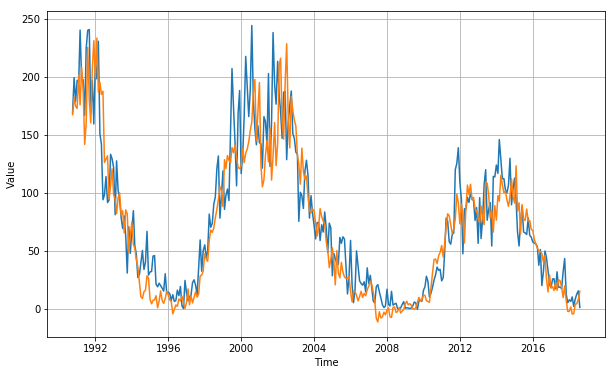

In [20]:
plt.figure(figsize=(10, 6))
time_valid = time[split_time:]
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() 

18.464119

<Figure size 432x288 with 0 Axes>

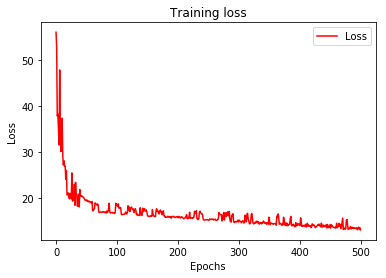

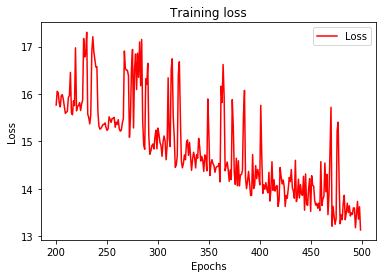

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [24]:
print(rnn_forecast)

[ 1.67481598e+02  1.82639618e+02  1.74771408e+02  1.72981110e+02
  2.01369644e+02  1.75958115e+02  2.08255081e+02  1.89107208e+02
  1.41918839e+02  1.59962982e+02  2.25432755e+02  1.80212158e+02
  1.60473251e+02  2.06806015e+02  2.31194611e+02  1.99623489e+02
  2.33473541e+02  1.86987625e+02  1.95311111e+02  1.84949677e+02
  1.87739120e+02  1.26352966e+02  1.29160034e+02  1.32100784e+02
  9.49054337e+01  1.06558586e+02  1.20932259e+02  9.88330994e+01
  9.46004486e+01  8.23694305e+01  9.60753479e+01  1.00222855e+02
  8.08662491e+01  8.48397980e+01  6.58271255e+01  8.56100769e+01
  8.21847153e+01  4.91395454e+01  6.33983917e+01  7.50056915e+01
  5.58695259e+01  5.26646881e+01  4.24809761e+01  3.66158791e+01
  2.33197651e+01  1.08699055e+01  9.30102158e+00  1.52014647e+01
  1.64676456e+01  2.88557110e+01  2.68923187e+01  8.39030743e+00
  4.76825237e+00  7.79069948e+00  8.14908791e+00  1.17088709e+01
  1.34503841e+00  6.96264219e+00  1.58469830e+01  7.59412336e+00
  5.06472588e+00  9.31683